# Part 3: Gradient Boosting with Bayesian  Sampling
The previous two notebooks walked through a basic Gradient Boosting (GBT) algorithm and a popular variation which utilized stochasticity.  Now we will turn our focus to another variation which deals with the shrinkage parameter.  Traditionally, the shrinkage parameter is a static parameter that is tuned using cross validation (CV).  In this variation we will be training a linear model to find a good candidate to use as the learning rate.  This can be done by finding the 'optimal' learning rate and then backfitting it in the Gradient Boosting algorithm.  However, this leads to overfitting the training data so we will apply the calculated learning rate in the next iteration.  We will still benefit from faster convergence over a static learning rate when using this forward-fitting method.

## Importing Packages
First, we need to import our packages.  The only difference between the packages used in our base Gradient Boosting and here are the packages "pymc3" and "tqdm."  Pymc3 will be used for Markov Chain Monte Carlo (MCMC) sampling of the posterior distribution of our learning rate and tqdm will be used to make a progress bar for our loop as this is a very computationally expensive algorithm.  Note: the comments from Pymc3 have been blocked as they can be verbose, especially when iteratively calling a sampler.

In [1]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle,resample
from tqdm import tqdm
import pymc3 as pm
import logging
logging.getLogger("pymc3").setLevel(logging.WARNING)

## Data Handling
The cell below loads and handles the data that we will be modeling which is the same dataset and split that was used in the Base_GBT and Stochastic_GBT notebooks.

In [2]:
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * .9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
xi = X_train
yi = y_train

## Parameter Initialization
The cell below initializes the parameters that will be used in the algorithm. Comments have been added in the code for further details. In addition, we initialize some datasets which we will be using to compare our algorithm with Scikit-Learn's.  We also build an empty dataframe that we will be appending the trace from the MCMC sampling to.

In [3]:
ei = 0 # initialization of error
predf = 0 # initial prediction 0
count = 1 # initial count we will reference 
test_predictions = 0 # initial test set prediction 0
mse_list_adap = [] #Creating the mse data set
lr = .01 #Setting the Learning rate
test_predictions_list = pd.DataFrame([])
mcmc_learning_rates = pd.DataFrame([]) #Dataset for MCMC samples

## Running the Algorithm
Below we run our algorithm.  The only difference can be seen after the 5th line of code where we implement our MCMC sampling, for ease of reading there are comments added into the code.

In [4]:
for i in tqdm(range(200)): # loop will make n trees, the more trees that are built increases complexity
                     #and the liklihood of overfitting.
    
    tree = DecisionTreeRegressor(max_depth=2) #Call Sklearn's decision tree 
    tree.fit(xi,yi)
    predi =  tree.predict(xi) #Training set predictions
    predicted =  tree.predict(X_test) #Test set predictions
    
    '''The if statement below is where we will be using Pymc3 to sample the posterior distribution of the learning rate.  
    Finding the learning rate is a rather simple problem which could be solved using the Metropolis algorithm, 
    but because the No U Turn Sampler (an extension of the Hamiltonian MCMC sampler) is self tuning and quicker 
    we have chosen to use that as our sampler.
    We define our model as E0 = alpha + tau*ei which is an approximation of the true equation y- EI = LR*(Predicted ei) given 
    that alpha is equal to the expected value of EI.  Upon inspection this holds true.  We use this approximation of the true 
    function because it converges better and ultimately it performs better.  With this specification, the next iteration's 
    learning rate will be equal to our estimate of tau.
    '''
    if count > 2:
        data = dict(x=ei, y=predf)
        with pm.Model() as model:

             pm.glm.GLM.from_formula('y ~ x', data)
            
             trace = pm.sample(1000,
                               init = 'jitter+adapt_diag',
                               tune = 1000, cores=2,
                               progressbar = False,
                               verbose=0)
        mcmc_learning_rates = pd.concat([mcmc_learning_rates,pm.trace_to_dataframe(trace).iloc[:,1].tail(500)],
                                        ignore_index = True, axis = 1)


        lr = np.mean(pm.trace_to_dataframe(trace).iloc[:,1].tail(500))
    #The first model is just the median, subsequent models will be trees built on the pseudo-residuals
    if count == 1:
        predf = np.median(yi)
        test_predictions = np.median(yi)
    else:
        predf = predf + lr*predi  # Final prediction will be previous prediction value + LR * new prediction of pseudo-residual
        test_predictions = test_predictions + lr*predicted #Final prediction on the Test Set.
        test_predictions_list = pd.concat([test_predictions_list,pd.DataFrame(test_predictions)],
                                          ignore_index = True, axis = 1)

    ei = y_train - predf  # Obtain the residual for the next iteration       
    yi = ei # Update our target variable to be the residual

    count += 1 #update our count
    test_mse = (np.mean((y_test - test_predictions)**2)) #Calculate MSE
    mse_list_adap.append(test_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [58:41<00:00, 17.61s/it]


## Model Comparison
Below we run the stochastic GBT from Scikit-Learn's package with a 0.9 subsample fraction.  The Test Set MSE's for each model are plotted and we can see that our computational expense had great benefits.  By iteration 25 our Bayesian sampled GBT had just about converged in error rate.  However, by iteration 200 the Bayesian sampled GBT had already overfit the training data.  In the long run (a thousand iterations) the stochastic GBT with a 0.01 learning rate achieves a lower Test MSE Score than our Bayesian variation.

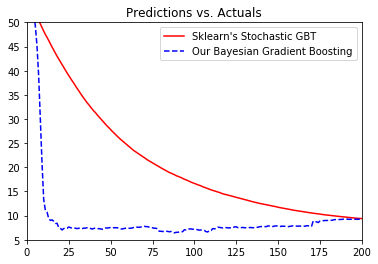

In [9]:
#List of the MSE's for each iteration
mse_list_adap = pd.DataFrame(mse_list_adap)

from sklearn.ensemble import GradientBoostingRegressor
n_est = 5000
rnd_reg = GradientBoostingRegressor(max_depth=2,
                                    n_estimators=n_est,
                                    subsample = .9,
                                    learning_rate=.01)
rnd_reg.fit(X_train,y_train)
predictions = rnd_reg.predict(X_test)
test_score = np.zeros((n_est,), dtype=np.float64)

for i, y_pred in enumerate(rnd_reg.staged_predict(X_test)):
    test_score[i] = (np.mean((y_test - y_pred)**2))

    

plt.plot(test_score, label = "Sklearn's Stochastic GBT", color = 'red')
plt.plot(mse_list_adap, label = 'Our Bayesian Gradient Boosting',
         color = 'blue', linestyle = 'dashed')
plt.xlim(0,200)
plt.ylim(5,50)
plt.legend()
plt.title('Test Set MSE')
plt.show()

## A Close Look at the Learning Rates
Now, let's take a look at the learning rates that we obtained using MCMC sampling at each iteration.  
We have 3 datasets based on our MCMC samples:
1. max_mcmc - the largest learning rate that was found in the learning rate's posterior after burn period. 
2. min_mcmc - the smallest learning rate that was found in the learning rate's posterior after burn period.
3. average_mcmc - the expected value of our posterior distribution after burn period, also the point estimate we used as our learning rate

The plot below graphs these three datasets with the red line being the average_mcmc.

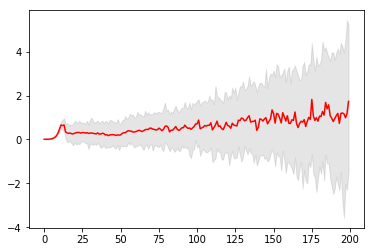

In [6]:
appendme = pd.DataFrame([.01,.01])
max_mcmc = (pd.DataFrame(np.max(mcmc_learning_rates, axis = 0)))
max_mcmc = appendme.append(max_mcmc, ignore_index = True)

appendme = pd.DataFrame([.01,.01])
min_mcmc = (pd.DataFrame(np.min(mcmc_learning_rates, axis = 0)))
min_mcmc = appendme.append(min_mcmc, ignore_index = True)

appendme = pd.DataFrame([.01,.01])
average_mcmc = pd.DataFrame(np.mean(mcmc_learning_rates,axis = 0))
average_mcmc = appendme.append(average_mcmc, ignore_index = True)


values = np.squeeze(pd.DataFrame(max_mcmc.index.values))
plt.plot(values,average_mcmc, color = 'red')
plt.fill_between(values,np.squeeze(max_mcmc),np.squeeze(min_mcmc), alpha = .2, color = 'grey')
plt.show()

In the plot above, we can clearly see that the uncertainty of our learning rate estimate (i.e. the width of the distribution around it) increases as our boosting algorithm iterates.  Next, we can see that the uncertainty really begins to be apparent around iteration 10.  Finally, the initial 10 iterations have a smooth, consistent shape, whereas what follows appears white noise around a line.

For an enhanced picture of the initial shape, the plot below only shows the first 50 iterations.

0    0.681924
dtype: float64


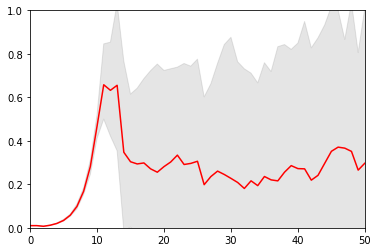

In [11]:
plt.plot(values,average_mcmc, color = 'red')
plt.fill_between(values,np.squeeze(max_mcmc),np.squeeze(min_mcmc), alpha = .2, color = 'grey')
plt.xlim(0,50)
plt.ylim(0,1)
plt.show()

## Approximating the Learning Rates
One aspect of the Gradient Boosting algorithm is that in order for the model to have a good trajectory, it is reliant on the initial values of the learning rate. For example, if we set the learning rate to 1 (i.e. no shrinkage) for the first 20 iterations and then set it to 0.01 it will converge to a very different test error than if it was initialized at 0.01.  Therefore, if we can use a function to approximate this initial shape we can achieve similar results without the expensive computations.  There are many candidate functions that can achieve this shape, however, we have chosen to use the beta PDF multiplied by a constant.  The beta PDF<sup>[1]</sup> is characterized by:
![Oops Something is wrong](beta_pdf.png "Beta PDF")

Why use the beta PDF?
1. The beta PDF is well researched and its characteristics are well understood
2. It can achieve many different shapes

A function which can achieve many different shapes is very important because it is doubtful that every dataset will have a similar shape.  This way, we can use parameter tuning to find parameters for the beta PDF which gives us a high performing shape, instead of running a linear model for each learning rate and then approximating that shape.  The picture below illustrates the flexibility of the beta PDF<sup>[1]</sup>.
![Oops Something is wrong](beta_distribution.png "Beta Shapes")
This flexibility comes at a cost, as we will now have an additional 5 parameters to tune.

Now that we have chosen a candidate function, we need to approximate the initial shape of our bayesian GBT's learning rate.  To do this we will use Scipy's Stats package.  For more info on Scipy please click <a href = https://docs.scipy.org/doc/scipy/reference/stats.html>here.</a>  After some parameter tuning using grid search we have arrived to the function seen below.

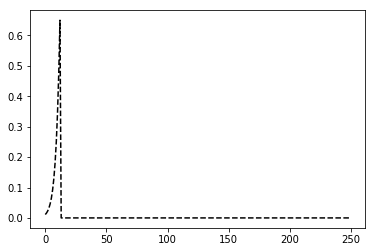

In [10]:
from scipy.stats import beta
Beta_LearningRate = []
for i in range(250):
    Beta_LearningRate.append(2*beta.pdf(i,26,1, scale=80, loc=-68)) 
plt.plot(Beta_LearningRate, color = 'black', linestyle = 'dashed')
plt.show()

One thing to notice is that after its peak the function quickly converges to 0.  One way to handle this is to simply add 0.01 to the end of our function to ensure it is still learning with each iteration. This convergence to 0 could be used as an early stopping criteria, but it most likely would be unstable and give poor CV results.

### Comparing the Learning Rates to our Approximation
Next, let's compare our approximate function with the true learning rates that we calculated.

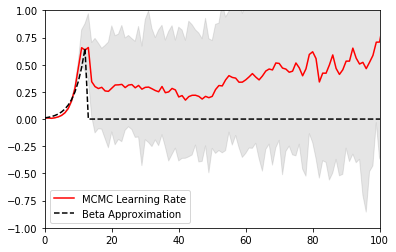

In [9]:
plt.plot(values,average_mcmc, color = 'red', label = 'MCMC Learning Rate')
plt.fill_between(values,np.squeeze(max_mcmc),np.squeeze(min_mcmc), alpha = .2, color = 'grey')
plt.xlim(0,100)
plt.ylim(-1,1)
plt.plot(Beta_LearningRate, color = 'black', linestyle = 'dashed', label = 'Beta Approximation')
plt.legend()
plt.show()

The function captures the initial shape we are interested in well. Importantly, it also does a good job at reacting to the uncertainty present in our learning rates.  When the uncertainty becomes quite pronounced our function drops to 0.  As mentioned earlier, we could just add 0.01 to the end of our function so that when we become uncertain of our learning rate it is simply set to a safe value.  Therefore, we can reap the benefits of modeling the learning rate: quicker convergence without overfitting our training data.

Up to this point, we have written a basic Gradient Boosting algorithm, added in stochasticity, and added an additonal model to set the learning rates and found an approximation of them.  The next notebook will close out our look at GBT's with an implementation utilizing our newly found candidate function.

1: https://en.wikipedia.org/wiki/Beta_function